In [1]:
import pandas as pd
import numpy as np

In [20]:
#Подготовка датастеа транзакций
def prepare_transactions(transactions):     
    transactions = transactions[transactions['sum']!=0]
    rare_sum_types = transactions.sum_type.value_counts()[6:].index.to_list()
    rare_cmmnt = transactions.cmmnt.value_counts()[6:].index.to_list()
    transactions.loc[transactions.sum_type.isin(rare_sum_types), 'sum_type'] = 'Редкий'
    transactions.loc[transactions.cmmnt.isin(rare_cmmnt), 'cmmnt'] = 'Редкий'
    transactions = transactions[transactions.cmmnt!="Корректировка записей регистров (ОПС)"]
    transactions = transactions.drop_duplicates(subset=['sum_type', 'cmmnt', 'sum', 'oprtn_date'])
    transactions.loc[:,'year'] = pd.to_datetime(transactions.oprtn_date, format='%Y-%m-%d').dt.year
    return transactions

#Выделение признаков у транзакций
def add_transaction_features(df, transactions):
    grouped = transactions.groupby(['accnt_id', 'sum_type', 'cmmnt'])['sum'].mean().reset_index(name='count')
    pivoted = grouped.pivot_table(index='accnt_id', 
                                columns=['sum_type', 'cmmnt'], 
                                values='count', 
                                fill_value=0)
    pivoted.columns = [f'{sum_type}_|_{cmmnt}' for sum_type, cmmnt in pivoted.columns]
    pivoted.reset_index(inplace=True)
    df = df.merge(pivoted, on='accnt_id', how='left')

    grouped2 = transactions.groupby(['accnt_id', 'sum_type'])['sum'].mean().reset_index(name='count')
    pivoted2 = grouped2.pivot_table(index='accnt_id', 
                                columns='sum_type', 
                                values='count', 
                                fill_value=0)
    pivoted2.columns = [f'{sum_type}' for sum_type in pivoted2.columns]
    pivoted2.reset_index(inplace=True)
    df = df.merge(pivoted2, on='accnt_id', how='left')

    grouped3 = transactions.groupby(['accnt_id', 'cmmnt'])['sum'].mean().reset_index(name='count')
    pivoted3 = grouped3.pivot_table(index='accnt_id', 
                                columns='cmmnt', 
                                values='count', 
                                fill_value=0)
    pivoted3.columns = [f'{cmmnt}' for cmmnt in pivoted3.columns]
    pivoted3.reset_index(inplace=True)

    df = df.merge(pivoted3, on='accnt_id', how='left')

    return df

#Пайплайн датафрейма с клиентами
def prepare_df(df, transactions):
    df = add_transaction_features(df, transactions)

    df.loc[np.bitwise_or(df.rgn == 'ЧУВАШСКАЯ РЕСПУБЛИКА ЧУВАШИЯ',df.rgn == 'ЧУВАШСКАЯ РЕСП' ), 'rgn'] = 'ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ'
    df.loc[df.rgn == 'Г МОСКВА', 'rgn'] = 'МОСКВА Г'
    df.loc[np.bitwise_or(df.rgn == 'КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС',df.rgn == 'КЕМЕРОВСКАЯ ОБЛ' ), 'rgn'] = 'КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС ОБЛ'
    df.loc[np.bitwise_or(df.rgn == 'ХАНТЫ-МАНСИЙСКИЙ АО',df.rgn == 'ХАНТЫ-МАНСИЙСКИЙ-ЮГРА АО' ), 'rgn'] = 'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА АО'
    df.loc[df.rgn == 'РЕСП БАШКОРТОСТАН', 'rgn'] = 'БАШКОРТОСТАН РЕСП'
    df = df.drop(['slctn_nmbr', 'clnt_id', 'accnt_id', 'brth_yr', 'accnt_bgn_date', 'brth_plc', 'dstrct', 'city', 'sttlmnt', 'pstl_code', 'okato'], axis=1)
    rare_regions = df.rgn.value_counts()[-15:].index
    rare_prvs_npf = df.prvs_npf.value_counts()[-140:].index
    df.loc[df.rgn.isin(rare_regions), 'rgn'] = "РЕДКИЙ"
    df.loc[df.prvs_npf.isin(rare_prvs_npf), 'prvs_npf'] = "РЕДКИЙ"
    df.loc[df.prvs_npf.isna(), 'prvs_npf'] = "НЕТ"
    
    df.fillna(0, inplace=True)
    return df

#Сохранение и выполнение пайплайнов для трейна
transactions = pd.read_csv('trnsctns_ops_trn.csv', encoding='cp1251', sep=';')
transactions = prepare_transactions(transactions)
contributors = pd.read_csv('cntrbtrs_clnts_ops_trn.csv', encoding='cp1251', sep=';')
contributors = prepare_df(contributors, transactions)
contributors_training = contributors.copy()
contributors_training.drop(bad_features, inplace = True, axis=1)

C:\Users\tolik\AppData\Local\Temp\ipykernel_1080\3543988033.py:63: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  contributors = pd.read_csv('cntrbtrs_clnts_ops_trn.csv', encoding='cp1251', sep=';')


In [21]:
#Сохранеие и выполнение пайпалайнов для теста
transactions_test = pd.read_csv('trnsctns_ops_tst.csv', encoding='cp1251', sep=';')
transactions_test = prepare_transactions(transactions_test)
contributors_test_basic = pd.read_csv('cntrbtrs_clnts_ops_tst.csv', encoding='cp1251', sep=';')
contributors_test = contributors_test_basic.copy()
contributors_test = prepare_df(contributors_test, transactions_test)
contributors_test.drop(bad_features, inplace = True, axis=1)

In [22]:
#Проверка, что признаки в выборках совпадают
common_features = list(set(contributors_training.columns) & set(contributors_test.columns))
contributors_training = contributors_training[common_features]
contributors_test = contributors_test[common_features]

In [23]:
from sklearn.model_selection import train_test_split

#Разделение трейна
X_train, X_test, y_train, y_test = train_test_split(contributors_training, contributors.erly_pnsn_flg, test_size=0.7, random_state=42)

#One hot encoding
categorical_columns = ['gndr', 'prvs_npf', 'addrss_type', 'rgn', 'phn', 'email', 'lk', 'assgn_npo', 'assgn_ops', ]
a = pd.get_dummies(pd.concat([X_train,X_test]), columns=categorical_columns)
X_train_encoded = a[:X_train.shape[0]]
X_test_encoded = a[X_train.shape[0]:]
columns = X_train_encoded.columns

In [8]:
#
# Удаление читерских признаков по очереди
#
#randomforest
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
bad_features_new = []
score = []

cur_columns = columns
threshold = 0.5
for i in range(X_test_encoded.shape[1]):
    dt = RandomForestClassifier(max_depth = 3, n_estimators=50, random_state=42)
    dt.fit(X_train_encoded, y_train)
    y_pred = dt.predict(X_test_encoded)
    root_feature = cur_columns[np.argmax(dt.feature_importances_)]
    print(f1_score(y_test, y_pred), root_feature)    
    score.append(f1_score(y_test, y_pred))
    if f1_score(y_test, y_pred) < threshold:
        break
    X_train_encoded = np.delete(X_train_encoded, np.argmax(dt.feature_importances_), axis=1)
    X_test_encoded = np.delete(X_test_encoded, np.argmax(dt.feature_importances_), axis=1)
    cur_columns = np.delete(cur_columns, np.argmax(dt.feature_importances_))
    bad_features_new.append(root_feature)
    

0.8706999793516416 ИД на страховые взносы на НЧ_|_Распределение ИД ОПС
0.8017729407118094 Страховые взносы на НЧ
0.782701834248226 Распределение ИД ОПС
0.7607646791078744 Поступление взносов ОПС
0.7053227417590259 Страховые взносы на НЧ_|_Поступление взносов ОПС
0.5182807399347117 ИД на страховые взносы на НЧ
0.4832349337195054 ИД на страховые взносы на НЧ_|_Поступление взносов ОПС


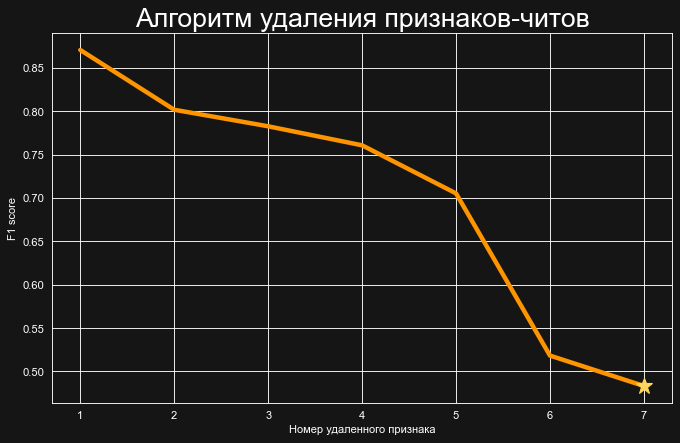

In [9]:
background_color = '#151515'
main_color1 = '#fd9400'
main_color2 = '#ffd65a'
font_color = 'white'

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6), dpi=80, facecolor=background_color)
ax.plot(np.arange(1, len(bad_features_new)+2), score, color=main_color1, linewidth=4)
ax.set_facecolor(background_color)
ax.set_xlabel('Номер удаленного признака', color=font_color)
ax.set_ylabel('F1 score', color=font_color)
ax.set_title('Алгоритм удаления признаков-читов', color=font_color, fontsize=24)
ax.tick_params(axis='x', colors=font_color)
ax.tick_params(axis='y', colors=font_color)
ax.spines['bottom'].set_color(font_color)
ax.spines['top'].set_color(font_color)
ax.spines['right'].set_color(font_color)
ax.spines['left'].set_color(font_color)
ax.set_xticks(np.arange(1, len(bad_features_new)+2))


ax.plot(len(bad_features_new)+1, score[-1], color=main_color2, marker='*', markersize=15)

plt.show()

In [35]:
#Обучение CatBoost + GridSearch для подбора гиперпараметров
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

bfn = list(set(bad_features_new).intersection(set(X_train.columns)))
cat_cols = list({'gndr', 'prvs_npf', 'addrss_type', 'rgn', 'phn', 'email', 'lk', 'assgn_npo',
                 'assgn_ops'}.intersection(set(X_train.columns)))

model = CatBoostClassifier(task_type='GPU',
                           devices='0',
                           verbose=100,
                           cat_features=cat_cols)

#Сетка параметров
param_grid = {  
                'iterations': [200],
                'depth': [4, 5, 6],
                'loss_function': ['Logloss', 'CrossEntropy'],
                'l2_leaf_reg': np.logspace(-20, -19, 3),
                'leaf_estimation_iterations': [10],
                'random_seed': [42]
            }
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid_search.fit(X_train.drop(bfn, axis=1), y_train)

params = grid_search.best_params_

0:	learn: 0.6135341	total: 28ms	remaining: 5.57s
100:	learn: 0.0308134	total: 1.9s	remaining: 1.86s
199:	learn: 0.0251277	total: 3.74s	remaining: 0us
0:	learn: 0.6140351	total: 21.2ms	remaining: 4.23s
100:	learn: 0.0293677	total: 1.98s	remaining: 1.94s
199:	learn: 0.0241945	total: 3.87s	remaining: 0us
0:	learn: 0.6136592	total: 17.3ms	remaining: 3.44s
100:	learn: 0.0284065	total: 1.9s	remaining: 1.86s
199:	learn: 0.0233524	total: 4.5s	remaining: 0us
0:	learn: 0.6146717	total: 20.9ms	remaining: 4.17s
100:	learn: 0.0289784	total: 14.2s	remaining: 13.9s
199:	learn: 0.0239404	total: 16.8s	remaining: 0us
0:	learn: 0.6140853	total: 28.5ms	remaining: 5.67s
100:	learn: 0.0293991	total: 15.7s	remaining: 15.4s
199:	learn: 0.0244292	total: 19.9s	remaining: 0us
0:	learn: 0.6135341	total: 24.5ms	remaining: 4.87s
100:	learn: 0.0308294	total: 6.28s	remaining: 6.16s
199:	learn: 0.0251920	total: 15.1s	remaining: 0us
0:	learn: 0.6140350	total: 22.6ms	remaining: 4.5s
100:	learn: 0.0293179	total: 2.13s	re

In [36]:
#Обучение модели на 1000 эпохах на лучших параметрах
model = CatBoostClassifier(iterations=1000,
                           loss_function=params['loss_function'],
                           depth=params['depth'],
                           l2_leaf_reg=params['l2_leaf_reg'],
                           eval_metric='F1',
                           leaf_estimation_iterations=10,
                           random_seed=42,
                           cat_features=cat_cols,
                           task_type='GPU',
                           devices='0'
                          )

model.fit(X_train.drop(bfn, axis=1), y_train)

y_pred = model.predict(X_test.drop(bfn, axis=1))

0:	learn: 0.7985604	total: 42.9ms	remaining: 42.9s
1:	learn: 0.7989298	total: 69.1ms	remaining: 34.5s
2:	learn: 0.7993827	total: 96.7ms	remaining: 32.1s
3:	learn: 0.8011930	total: 124ms	remaining: 30.9s
4:	learn: 0.7998355	total: 151ms	remaining: 30s
5:	learn: 0.7933423	total: 177ms	remaining: 29.4s
6:	learn: 0.7945404	total: 205ms	remaining: 29s
7:	learn: 0.7956235	total: 232ms	remaining: 28.8s
8:	learn: 0.7972388	total: 259ms	remaining: 28.5s
9:	learn: 0.7981472	total: 289ms	remaining: 28.6s
10:	learn: 0.8004926	total: 314ms	remaining: 28.3s
11:	learn: 0.8136828	total: 347ms	remaining: 28.6s
12:	learn: 0.8140500	total: 378ms	remaining: 28.7s
13:	learn: 0.8179159	total: 405ms	remaining: 28.5s
14:	learn: 0.8185484	total: 432ms	remaining: 28.4s
15:	learn: 0.8193717	total: 460ms	remaining: 28.3s
16:	learn: 0.8250475	total: 489ms	remaining: 28.3s
17:	learn: 0.8262433	total: 518ms	remaining: 28.3s
18:	learn: 0.8265337	total: 545ms	remaining: 28.1s
19:	learn: 0.8283953	total: 572ms	remainin

In [37]:
#Подсчет метрик
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score

f1 = f1_score(y_test, y_pred)   
proba = model.predict_proba(X_test.drop(bfn, axis =1))
roc_auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC AUC Score: {roc_auc}")
print(f"F1 Score: {f1}")

Precision: 0.9428888712619973
Recall: 0.8741083903228178
ROC AUC Score: 0.9360524671806421
F1 Score: 0.9071968251545448


ValueError: x and y must have same first dimension, but have shapes (200,) and (1000,)

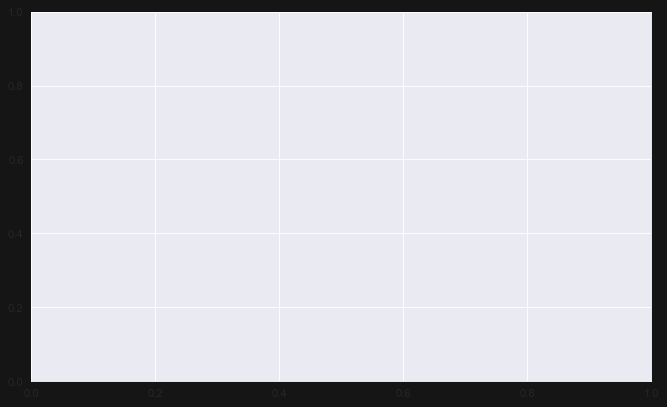

In [38]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=80, facecolor=background_color)
ax.plot(np.arange(1, 201), model.evals_result_['learn']['Logloss'], color=main_color1, linewidth=4)
ax.set_facecolor(background_color)
ax.set_xlabel('Итерация', color=font_color)
ax.set_ylabel('Logloss', color=font_color)
ax.set_title('Обучение модели CatBoost', color=font_color, fontsize=24)
ax.tick_params(axis='x', colors=font_color)
ax.tick_params(axis='y', colors=font_color)
ax.spines['bottom'].set_color(font_color)
ax.spines['top'].set_color(font_color)
ax.spines['right'].set_color(font_color)
ax.spines['left'].set_color(font_color)

plt.show()

In [39]:
# Поменять порядок колонок в тесте
contributors_test = contributors_test[X_test.columns]

In [40]:
#Получение предсказаний на тесте
y_test_pred = model.predict(contributors_test.drop(bfn, axis=1))

In [42]:
#Создание submission.csv
submission = pd.read_csv('sample_submission.csv', encoding='cp1251', sep=',')
ans = pd.DataFrame({'accnt_id': contributors_test_basic.accnt_id, 'erly_pnsn_flg': y_test_pred})
# delete erly_pnsn_flg
submission = submission.drop('erly_pnsn_flg', axis=1)
submission = submission.merge(ans, on='accnt_id', how='left')
# set erly_pnsn_flg type as int64
submission.erly_pnsn_flg = submission.erly_pnsn_flg.astype(int)
submission.to_csv('submission_cb.csv', index=False)

In [43]:
submission

,accnt_id,erly_pnsn_flg
0,0x828738D13E70E44D9A97F595ADBC4A33,0
1,0xA4F3243B96C17B4B93C3663D72B69908,0
2,0xFBBAE15788845B4D8157D792BB6222F9,0
3,0xB98E7310C5553FEB476161B4D476ADD2,0
4,0x86E0FDE4D9B0194B90DC0B1451D33AD1,0
...,...,...
94024,0x943D2C768A4FB38311E658EB44E446BF,0
94025,0x0AC44A307F9EC94A9EDE212B742516C8,0
94026,0x0C740A2321B65B4E979FE15EB6AB38A2,0
94027,0x943D2C768A4FB38311E65DD7AF1A5927,0
